##### Importing libraries

In [2]:
pip install torch


  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/c7/1d/de42543b890ecbfc74786fdfdf80207f52c157fae4ac4c76612a8bb27a4a/torch-2.1.1-cp39-cp39-win_amd64.whl.metadata
   ---------------------------------------- 0.0/192.2 MB ? eta -:--:--
   ---------------------------------------- 0.1/192.2 MB 1.9 MB/s eta 0:01:41
   ---------------------------------------- 0.3/192.2 MB 4.4 MB/s eta 0:00:44
   ---------------------------------------- 1.1/192.2 MB 9.7 MB/s eta 0:00:20
    --------------------------------------- 2.6/192.2 MB 16.4 MB/s eta 0:00:12
   - -------------------------------------- 4.8/192.2 MB 23.6 MB/s eta 0:00:08
   - -------------------------------------- 7.3/192.2 MB 31.0 MB/s eta 0:00:06
   -- ------------------------------------- 10.0/192.2 MB 33.6 MB/s eta 0:00:06
   -- ------------------------------------- 13.2/192.2 MB 59.5 MB/s eta 0:00:04
   --- ------------------------------------ 16.1/192.2 MB 65.6 MB/s eta 0:00:03
   --- --------

In [8]:
!pip install langdetect
!pip install wordcloud
!pip install vadersentiment

     ---------------------------------------- 0.0/126.0 kB ? eta -:--:--
     --- ------------------------------------ 10.2/126.0 kB ? eta -:--:--
     --------- --------------------------- 30.7/126.0 kB 435.7 kB/s eta 0:00:01
     ------------------------ ------------ 81.9/126.0 kB 762.6 kB/s eta 0:00:01
     ------------------------------------ 126.0/126.0 kB 925.7 kB/s eta 0:00:00


In [10]:
import torch
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification
import pandas as pd
import numpy as np
from langdetect import detect
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english')) - {'not'}
from wordcloud import WordCloud
import re

##### Importing File for Prediction

In [11]:
prediction_reviews=pd.read_csv('Air_Frier.csv')

In [12]:
prediction_reviews.head(2)

,Date Info,Country Info,Name,Review Title,Content,Rating,Link,Product Title
0,"November 11, 2023",Reviewed in the United States,Amazon Customer,4.0 out of 5 stars,I was amazed at the different processes for th...,4.0 out of 5 stars,/Kitchen-box-Convection-Countertop-Accessories...,"32 QT Digital Toaster Oven Air Fryer Combo, Ki..."
1,"November 12, 2023",Reviewed in the United States,Beth Case,4.0 out of 5 stars,Our oven died and we can't get another one in ...,4.0 out of 5 stars,/Kitchen-box-Convection-Countertop-Accessories...,"32 QT Digital Toaster Oven Air Fryer Combo, Ki..."


##### Taking Rating and Content

In [13]:
prediction_reviews=prediction_reviews[['Rating','Content']]

##### Removing other language reviews we are taking reviews that our model train on in english

In [14]:
# Add a new column 'Language' with the detected language
prediction_reviews['Language'] = prediction_reviews['Content'].apply(lambda x: detect(x) if pd.notnull(x) else None)
prediction_reviews = prediction_reviews[prediction_reviews['Language'] == 'en']
prediction_reviews = prediction_reviews.drop(columns=['Language'])
prediction_reviews = prediction_reviews.reset_index(drop=True)

##### Dropping Null and Duplicates

In [15]:
prediction_reviews = prediction_reviews.dropna()
prediction_reviews = prediction_reviews.drop_duplicates()
prediction_reviews = prediction_reviews.reset_index(drop=True)

##### Loading the Model

In [16]:
tokenizer = BertTokenizer.from_pretrained('Tokenizer_0.99')
model = BertForSequenceClassification.from_pretrained("CustomModel_0.99")

#####  Labels for the data

In [17]:
original_labels = [
    'Adaptability', 'Durability', 'Ease of Use', 'Ergonomics',
    'Interference', 'Performance', 'Use Efficiency', 'Aesthetics',
    'Ease of Reprocessing', 'Ease of Storage', 'Price', 'Safety'
]

# Map labels to numerical values (0 to 12)
labeling_dict = {label: idx for idx, label in enumerate(original_labels)}

##### Predict the aspect of the data 

In [18]:
# Function to predict aspect
def predict_aspect(text):
    encoded_input = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    output = model(**encoded_input)
    logits = output.logits.detach().cpu().numpy()
    y_pred = np.argmax(logits, axis=-1)
    given_value = y_pred[0] # Predic the Aspect based on Review
    result_key = next(key for key, value in labeling_dict.items() if value == given_value) # GIve the actual aspect after model gives use numerical value
    return result_key # return the results in string (text) Form 

# Apply the predict_aspect function to the 'Content' column one by one 
prediction_reviews['Predicted_Aspect'] = prediction_reviews['Content'].apply(predict_aspect)


##### Checking Output 

In [19]:
prediction_reviews.head(2)

,Rating,Content,Predicted_Aspect
0,4.0 out of 5 stars,I was amazed at the different processes for th...,Adaptability
1,4.0 out of 5 stars,Our oven died and we can't get another one in ...,Aesthetics


##### cleaning data using re.sub technique remove whitespaces , punctuations , comma , any hashtags 

In [20]:
def cleaning_text(sentence) :
    sentence = re.sub(r'http\S+\s*|\W+|#\S+|[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]|\s+|[0-9]', ' ', sentence.lower())
    return sentence

##### applying tokenization and lemmatization 

In [21]:
def tokenization_lemmatize_stopwording(sentence):
    tokens = [lemmatizer.lemmatize(word) for word in word_tokenize(sentence) if word not in stop_words]
    return ' '.join(tokens)

##### applying vader library to calculate the sentiment analysis using polarity score technique .

In [22]:
# Function to print sentiments of the sentence.
def sentiment_scores(sentence):
    cleaned_sentence = tokenization_lemmatize_stopwording(cleaning_text(sentence))
    sid_obj = SentimentIntensityAnalyzer()
    sentiment_dict = sid_obj.polarity_scores(cleaned_sentence)
    
    sentiment_score = sentiment_dict['compound']
    
    if sentiment_score >= 0.05:
        sentiment_label = "Positive"
    elif sentiment_score <= -0.05:
        sentiment_label = "Negative"
    else:
        sentiment_label = "Neutral"
    
    return sentiment_label, sentiment_score

##### Append Most Common Keywords in a Sentence Based on Calculating Word Cloud 

In [23]:
# Function to get the most common words in a sentence
def get_most_common_words(sentence, num_words=2):
    sentence=tokenization_lemmatize_stopwording(cleaning_text(sentence))
    words = word_tokenize(sentence.lower())
    freq_dist = FreqDist(words)
    most_common_words = [word for word, _ in freq_dist.most_common(num_words)]
    return most_common_words


##### Getting Sentiment Label Sentiment Score , and Common Words

In [24]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\khali\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [25]:
prediction_reviews[['Sentiment_Label', 'Sentiment_Score']] = prediction_reviews['Content'].apply(sentiment_scores).apply(pd.Series)
prediction_reviews["Common_Words"] = prediction_reviews['Content'].apply(lambda x: ", ".join(get_most_common_words(x,3)))

##### Getting Content , Predicted Aspect , Sentiment Label , Sentiments Score Common Words 

In [26]:
prediction_reviews.head(2)

,Rating,Content,Predicted_Aspect,Sentiment_Label,Sentiment_Score,Common_Words
0,4.0 out of 5 stars,I was amazed at the different processes for th...,Adaptability,Positive,0.9403,"oven, mode, pan"
1,4.0 out of 5 stars,Our oven died and we can't get another one in ...,Aesthetics,Positive,0.4215,"get, u, photo"


In [35]:
prediction_reviews.to_csv('prediction_results.csv',index=False)

##### Visualization Sentiment Label 

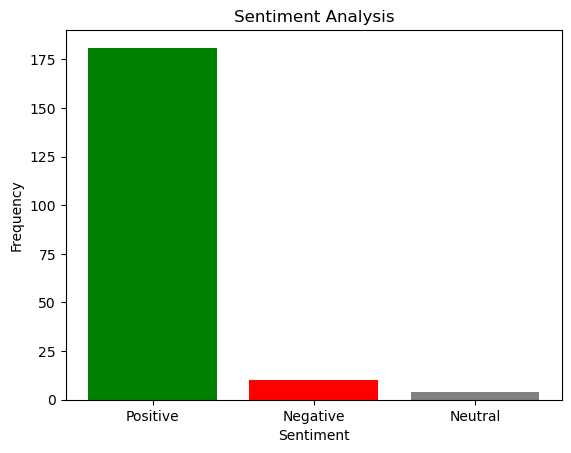

In [34]:
# Assuming you already have a DataFrame named 'amazon_reviews_data' with 'Sentiment_Label' column
# Create a bar chart
sentiment_counts = prediction_reviews['Sentiment_Label'].value_counts()

# Plot the bar chart
plt.bar(sentiment_counts.index, sentiment_counts.values, color=['green', 'red', 'gray'])

# Add labels and title
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.title('Sentiment Analysis')

# Show the plot
plt.show()


##### Generate Word Cloud For Positive and Negative Reviews .

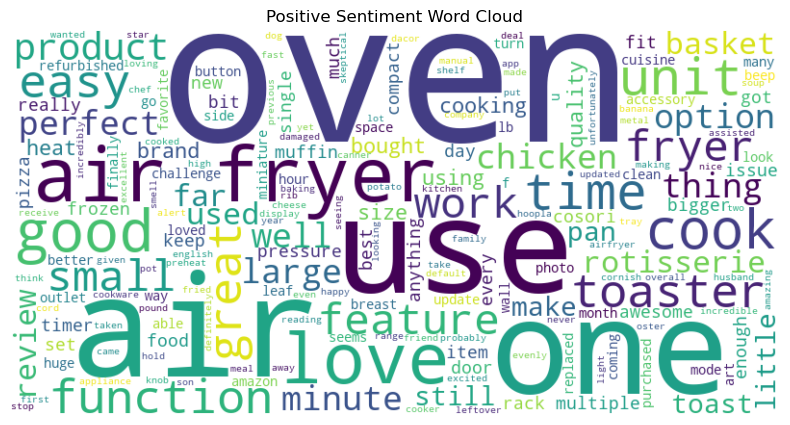

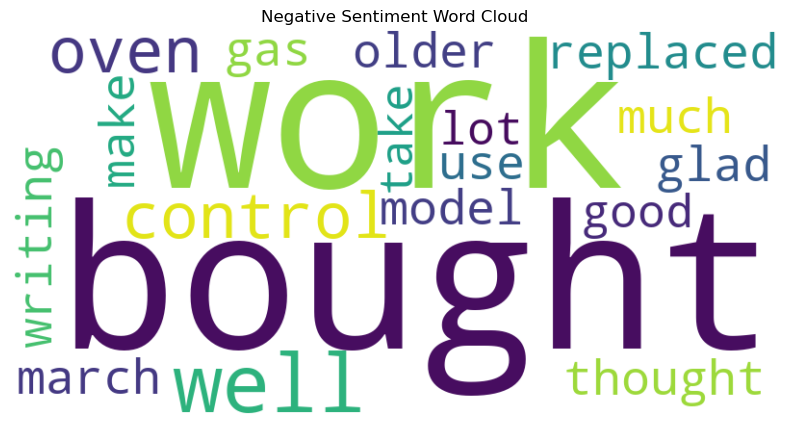

In [30]:
# Assuming you have a DataFrame named 'amazon_reviews_data' with a 'Sentiment_Label' column and a 'Common Words' column

# Function to generate word cloud
def generate_wordcloud(sentiment_label):
    # Filter data for the specific sentiment
    sentiment_data = prediction_reviews[prediction_reviews['Sentiment_Label'] == sentiment_label]
    
    # Concatenate all common words for the sentiment
    all_words = ' '.join(sentiment_data['Common_Words'])
    
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)
    
    # Plot the WordCloud image
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'{sentiment_label} Sentiment Word Cloud')
    plt.show()

# Generate word cloud for Positive sentiment
generate_wordcloud('Positive')

# Generate word cloud for Negative sentiment
generate_wordcloud('Negative')

##### Visualizing Aspect of the data

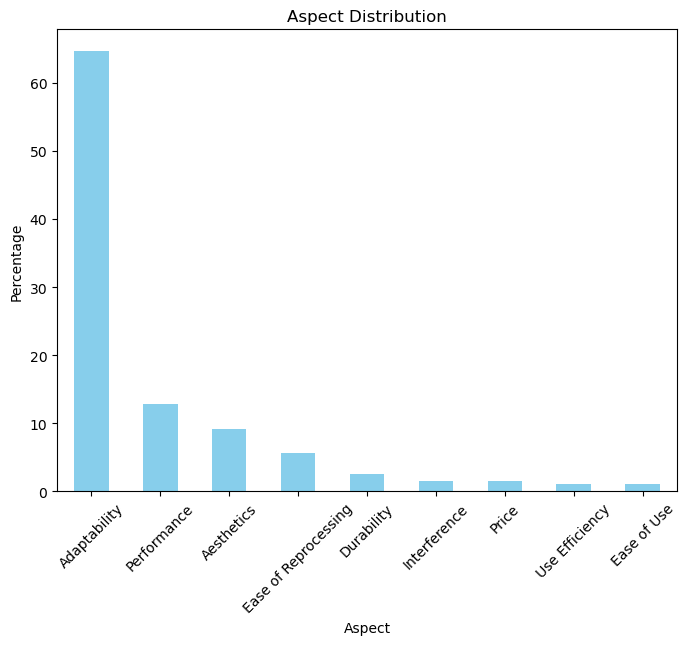

In [31]:
# Calculate percentage of each aspect
aspect_percentage = prediction_reviews['Predicted_Aspect'].value_counts(normalize=True) * 100

# Plot the aspect percentages
plt.figure(figsize=(8, 6))
aspect_percentage.plot(kind='bar', color='skyblue')
plt.title('Aspect Distribution')
plt.xlabel('Aspect')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.show()